#### 1. K-Means

##### Example 1. Random generated data

In [1]:
'''
input: 3 random point clusters following Gaussian distribution,
        given expectations and covariance matrices
output: 3 clusters
'''

'\ninput: 3 random point clusters following Gaussian distribution,\n        given expectations and covariance matrices\noutput: 3 clusters\n'

initiate random data

In [21]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(11)

# parameters - means and covariances
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]

# number of points per group
N = 500

# init random points following Gaussian dist.
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)
# concat into vector
X = np.concatenate((X0, X1, X2), axis = 0)

# number of clusters
K = 3

# assign labels
original_label = np.asarray([0]*N + [1]*N + [2]*N).T

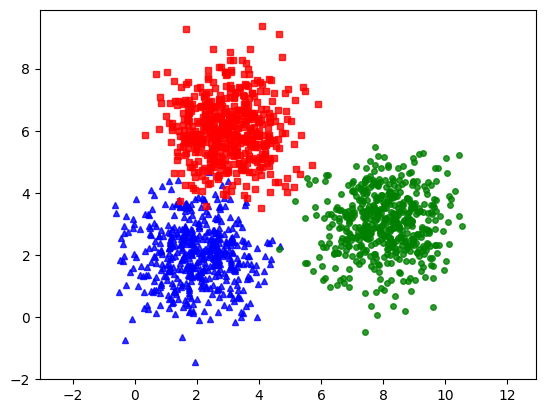

In [3]:
# visualize
def kmeans_display(X, label):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    
    plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    plt.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)

    plt.axis('equal')
    plt.plot()
    plt.show()

kmeans_display(X, original_label)

build model (using numpy)

In [4]:
'''step 1'''
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

'''step 2'''
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

'''step 3'''
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster 
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

'''stop condition'''
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [5]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0 
    while (it < 100000):
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break
        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

run model

In [22]:
X.shape

(1500, 2)

Centers found by our algorithm:
[[2.99084705 6.04196062]
 [1.97563391 2.01568065]
 [8.03643517 3.02468432]]


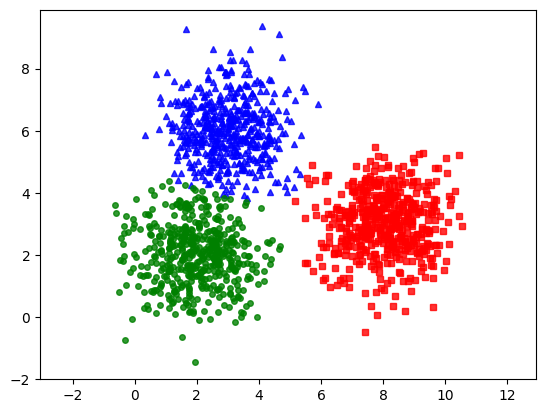

In [6]:
# call to model
(centers, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:')
print(centers[-1])

# display result visually
kmeans_display(X, labels[-1])

In [7]:
centers[-1]

array([[2.99084705, 6.04196062],
       [1.97563391, 2.01568065],
       [8.03643517, 3.02468432]])

built-in model (sklearn)

c:\Users\Admin\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Centers found by scikit-learn:
[[2.99357611 6.03605255]
 [8.0410628  3.02094748]
 [1.97634981 2.01123694]]


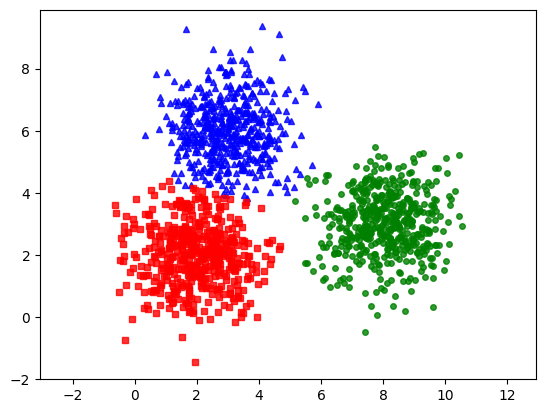

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(kmeans.cluster_centers_)
pred_label = kmeans.predict(X)
kmeans_display(X, pred_label)

##### Example 2. Handwritten Digits

read data from zip file

In [9]:
# import library
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

# define paths
data_path = 'D:/python/pyforml/week04_multinomial-regression/homework'
# train path
train_img_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [10]:
# extract and read data from file
def get_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    import gzip # to decompress gz (zip) file

    # read training data
    f_images = gzip.open(images_path,'r')

    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)

    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)

    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)

    # convert into images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)

    # read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)

    labels = np.zeros((real_num)).astype(np.int64)

    # rearrange to correspond images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        images = images[rand_id, :]
        labels = labels[rand_id,]
        
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [11]:
# call read input method
train_images, train_labels = get_data(
    train_img_path, train_labels_path, 5000, shuffle=True)

print(train_images.shape, train_labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19836\2973448575.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)


kmeans

In [12]:
X = np.asarray(train_images)/256.0
K = 10
kmeans = KMeans(n_clusters=K).fit(X)
pred_label = kmeans.predict(X)

c:\Users\Admin\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


visualize

In [13]:
# This function visualizes filters in matrix A. Each column of A is a
# filter. We will reshape each column into a square image and visualizes
# on each cell of the visualization panel.
# All other parameters are optional, usually you do not need to worry
# about it.
# opt_normalize: whether we need to normalize the filter so that all of
# them can have similar contrast. Default value is true.

# opt_graycolor: whether we use gray as the heat map. Default is true.
# opt_colmajor: you can switch convention to row major for A. In that
# case, each row of A is a filter. Default value is false.
# source: https://github.com/tsaith/ufldl_tutorial

def display_network(A, m = -1, n = -1):
    opt_normalize = True
    opt_graycolor = True

    # Rescale
    A = A - np.average(A)

    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    if m < 0 or n < 0:
        n = np.ceil(np.sqrt(col))
        m = np.ceil(col / n)

    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
    
    if not opt_graycolor:
        image *= 0.1
    
    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            clim = np.max(np.abs(A[:, k]))
            
            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1
    return image

In [14]:
def display_color_network(A):
    """
    # display receptive field(s) or basis vector(s) for image patches
    #
    # A the basis, with patches as column vectors
    # In case the midpoint is not set at 0, we shift it dynamically
    :param A:
    :param file:
    :return:
    """
    if np.min(A) >= 0:
        A = A - np.mean(A)
    
    cols = np.round(np.sqrt(A.shape[1]))
    channel_size = A.shape[0] / 3
    dim = np.sqrt(channel_size)
    dimp = dim + 1

    rows = np.ceil(A.shape[1] / cols)

    B = A[0:channel_size, :]
    C = A[channel_size:2 * channel_size, :]
    D = A[2 * channel_size:3 * channel_size, :]

    B = B / np.max(np.abs(B))
    C = C / np.max(np.abs(C))
    D = D / np.max(np.abs(D))

    # Initialization of the image
    image = np.ones(shape=(dim * rows + rows - 1, dim * cols + cols - 1, 3))
    
    for i in range(int(rows)):
        for j in range(int(cols)):
            # This sets the patch
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 0] = B[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 1] = C[:, i * cols + j].reshape(dim, dim)
            image[i * dimp:i * dimp + dim, j * dimp:j * dimp + dim, 2] = D[:, i * cols + j].reshape(dim, dim)
    
    image = (image + 1) / 2
    
    return image

<class 'numpy.ndarray'>
(784, 10)


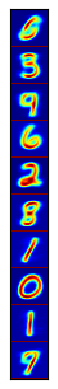

In [15]:
print(type(kmeans.cluster_centers_.T))
print(kmeans.cluster_centers_.T.shape)
A = display_network(kmeans.cluster_centers_.T, K, 1)

f1 = plt.imshow(A, interpolation='nearest', cmap = "jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)
plt.show()
# plt.savefig('a1.png', bbox_inches='tight')

# a colormap and a normalization instance
cmap = plt.cm.jet
norm = plt.Normalize(vmin=A.min(), vmax=A.max())

# map the normalized data to colors
# image is now RGBA (512x512x4)
image = cmap(norm(A))

visualize result

In [16]:
N0 = 20;
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))

for k in range(K):
    Xk = train_images[pred_label == k, :]
    center_k = [kmeans.cluster_centers_[k]]
    neigh = NearestNeighbors(n_neighbors=N0).fit(Xk)
    dist, nearest_id = neigh.kneighbors(center_k, N0)
    X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
    X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

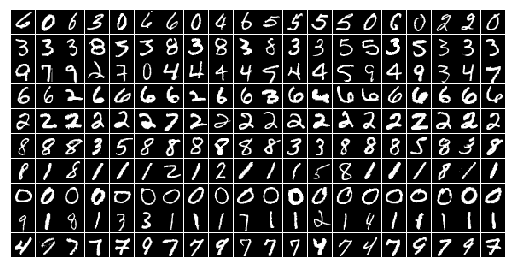

In [17]:
plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest')
plt.gray()
plt.show()

#### 2. Gaussian Mixture (EM Algorithm) 

Random generated 2D data

In [28]:
from numpy import random

def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

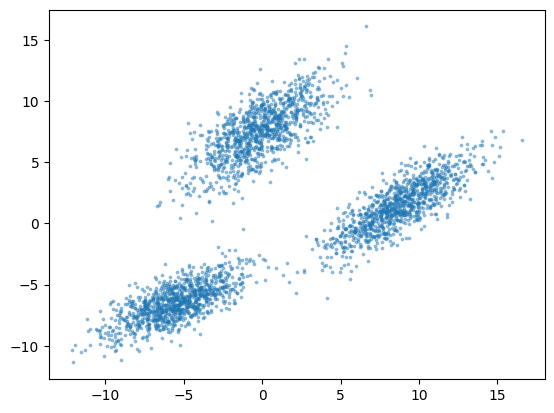

In [35]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [36]:
X.shape

(3000, 2)

In [25]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

build Gaussian Mixture model

In [26]:
class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
    
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)
    
    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [ ]:
# create a Gaussian Mixture Model
gmm = GMM(3, 2)

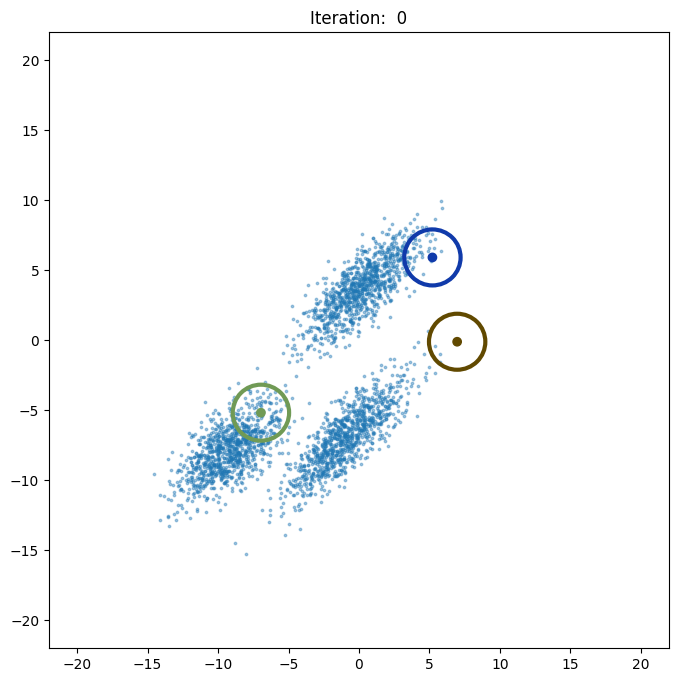

Iteration: 1, log-likelihood: -15821.7210


<Figure size 640x480 with 0 Axes>

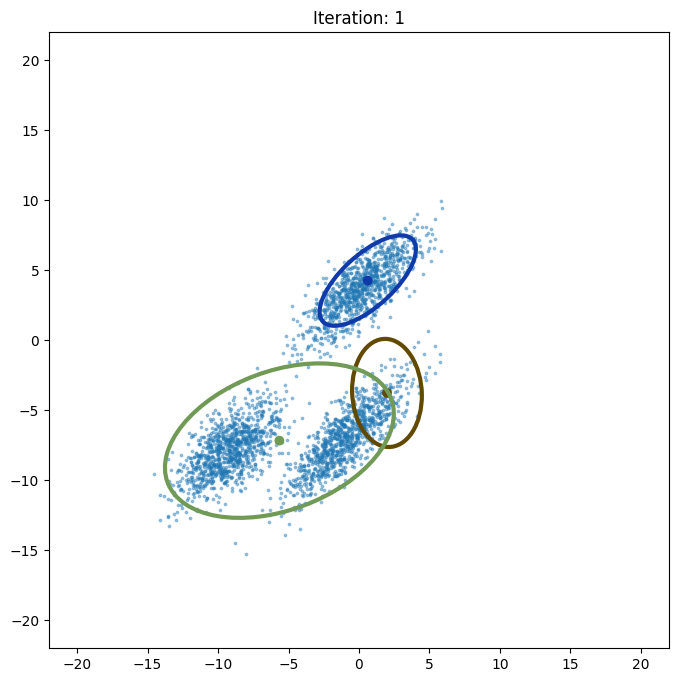

Iteration: 2, log-likelihood: -15478.4172


<Figure size 640x480 with 0 Axes>

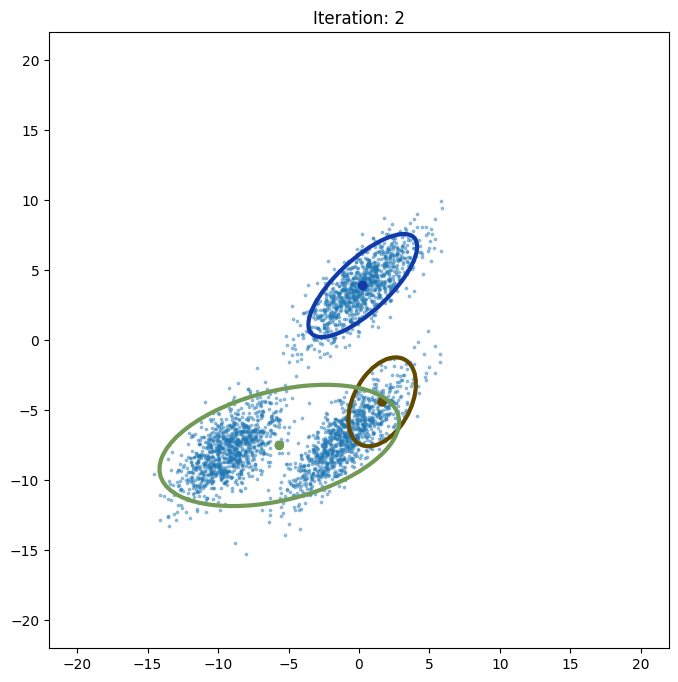

Iteration: 3, log-likelihood: -15387.3450


<Figure size 640x480 with 0 Axes>

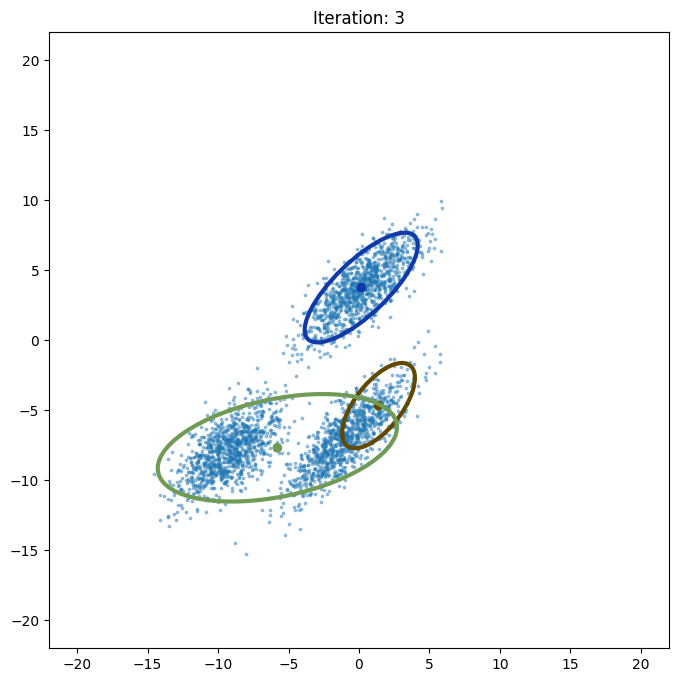

Iteration: 4, log-likelihood: -15341.0780


<Figure size 640x480 with 0 Axes>

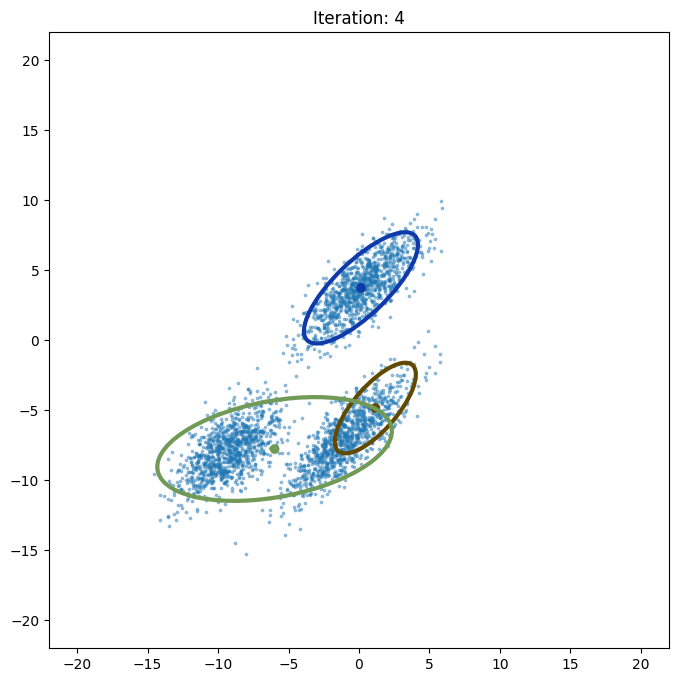

Iteration: 5, log-likelihood: -15294.3434


<Figure size 640x480 with 0 Axes>

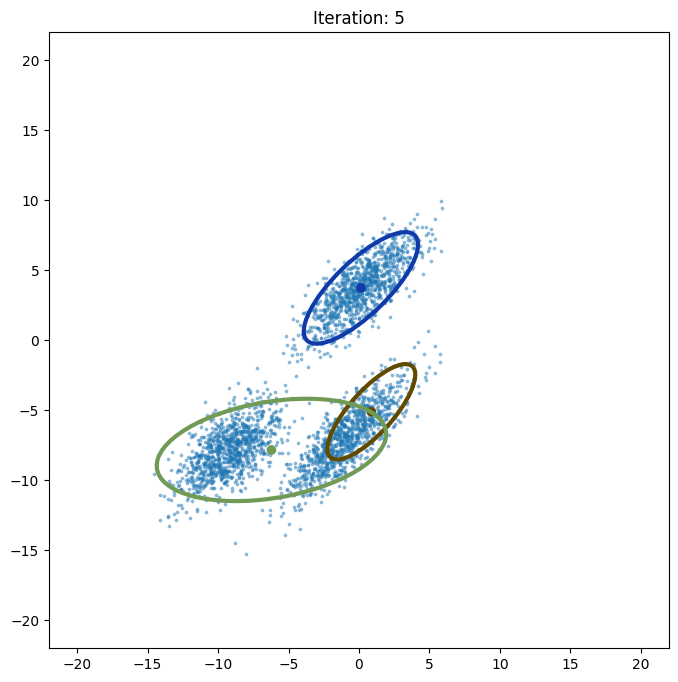

Iteration: 6, log-likelihood: -15244.5149


<Figure size 640x480 with 0 Axes>

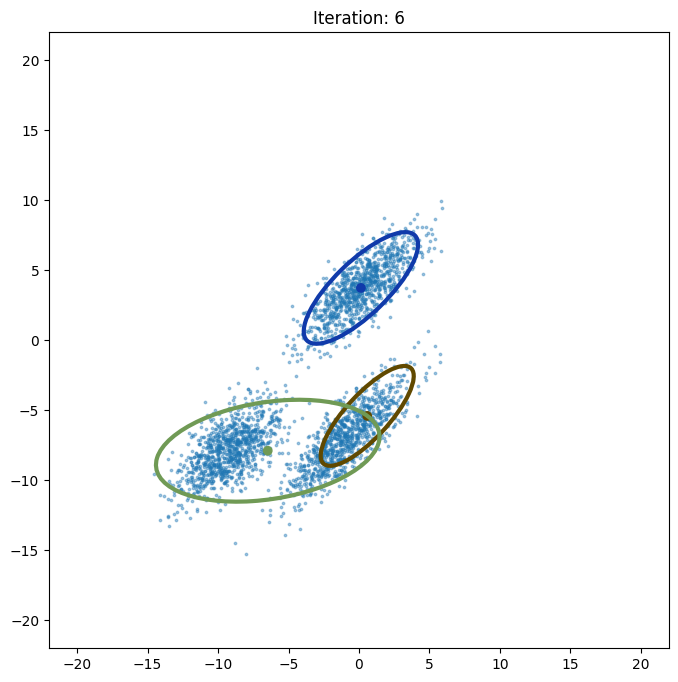

Iteration: 7, log-likelihood: -15192.3255


<Figure size 640x480 with 0 Axes>

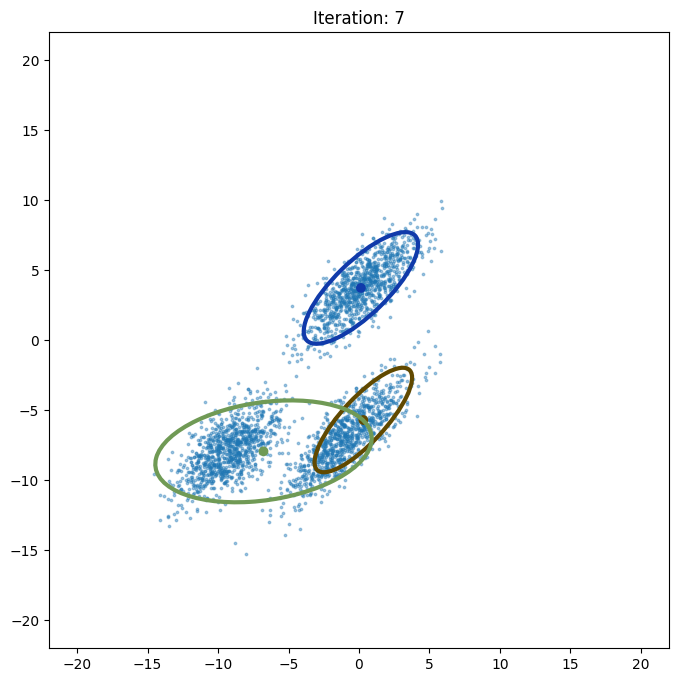

Iteration: 8, log-likelihood: -15138.1337


<Figure size 640x480 with 0 Axes>

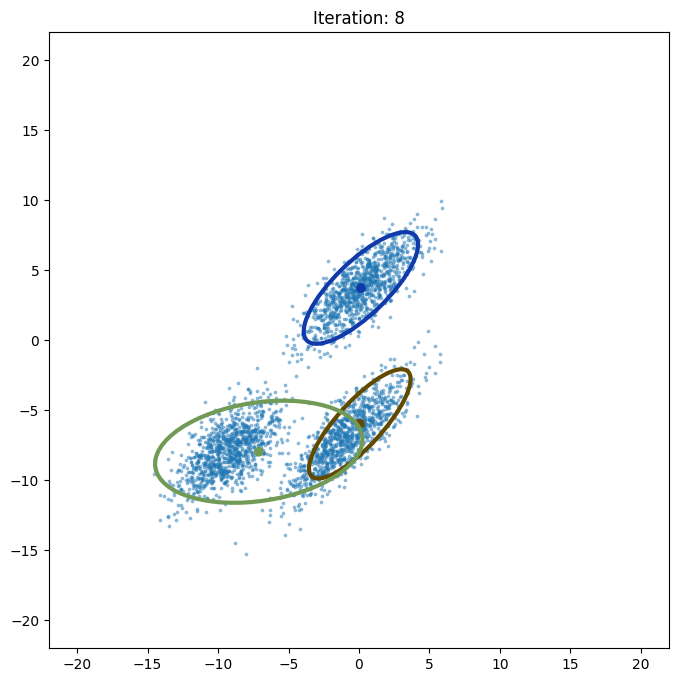

Iteration: 9, log-likelihood: -15080.2463


<Figure size 640x480 with 0 Axes>

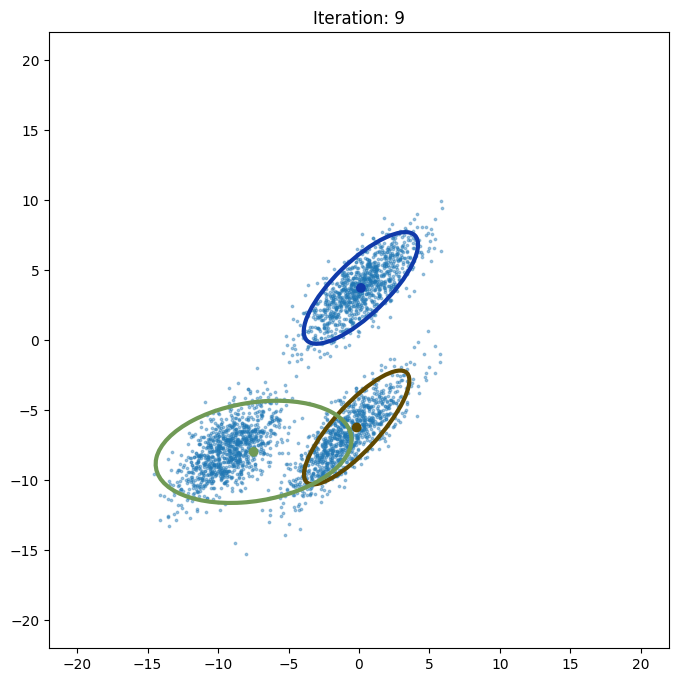

Iteration: 10, log-likelihood: -15012.6218


<Figure size 640x480 with 0 Axes>

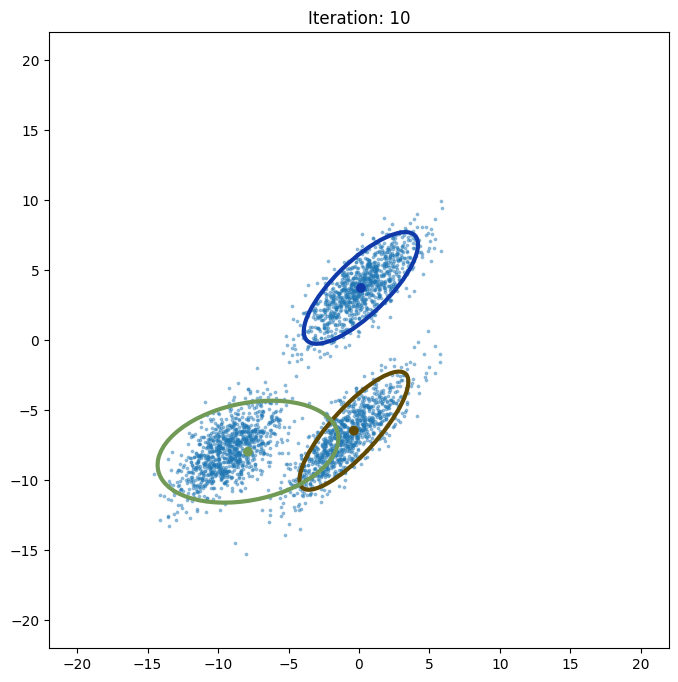

Iteration: 11, log-likelihood: -14922.8883


<Figure size 640x480 with 0 Axes>

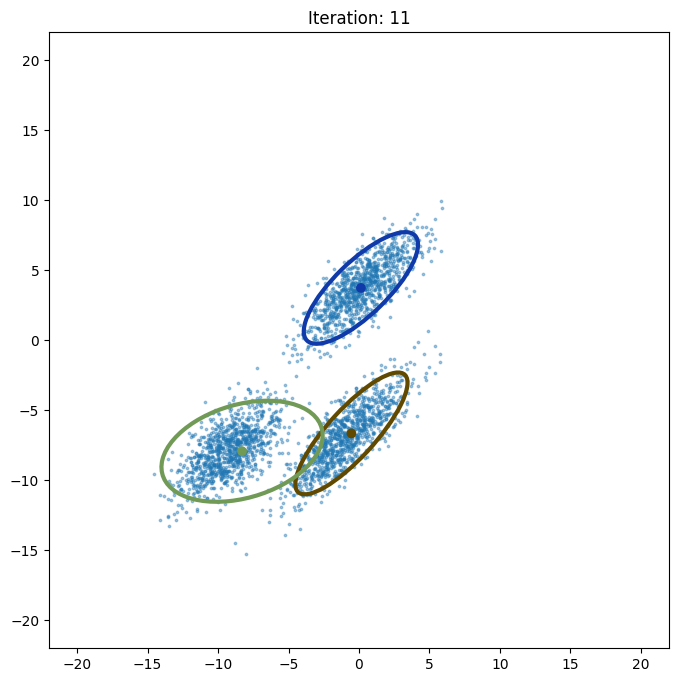

Iteration: 12, log-likelihood: -14799.0489


<Figure size 640x480 with 0 Axes>

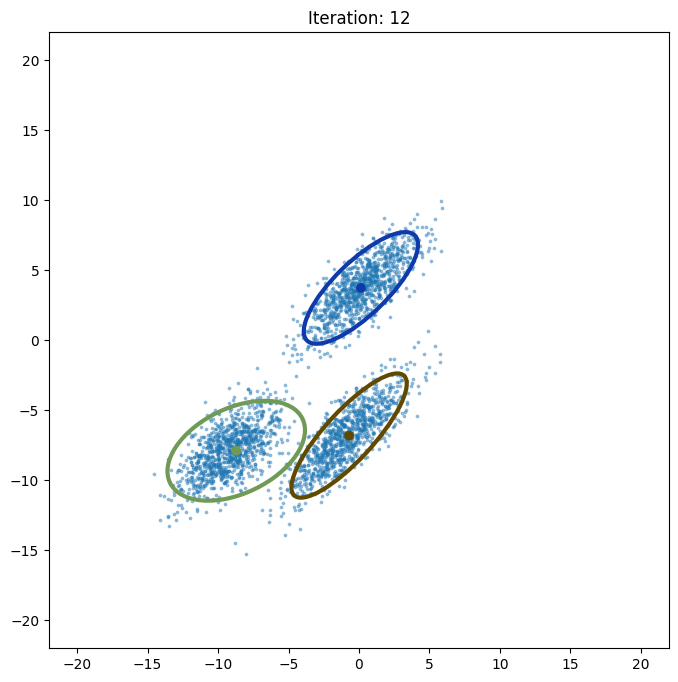

Iteration: 13, log-likelihood: -14675.1260


<Figure size 640x480 with 0 Axes>

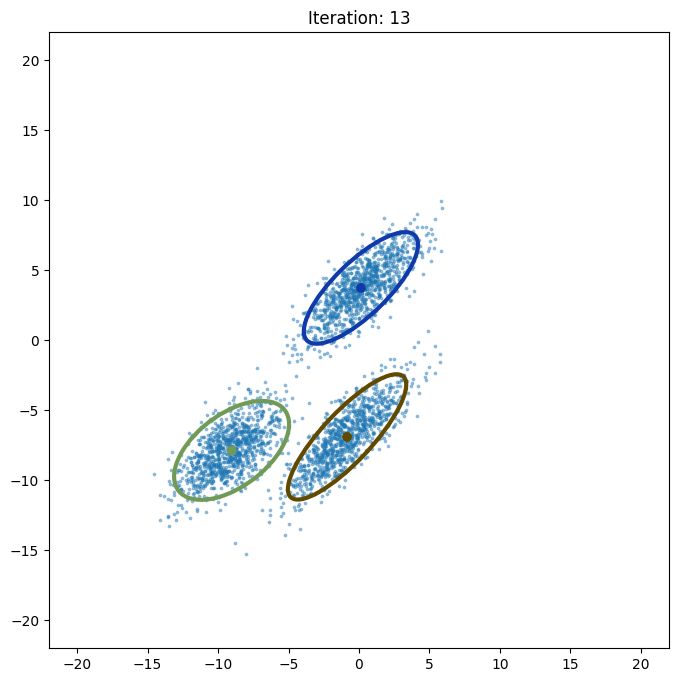

Iteration: 14, log-likelihood: -14636.9535


<Figure size 640x480 with 0 Axes>

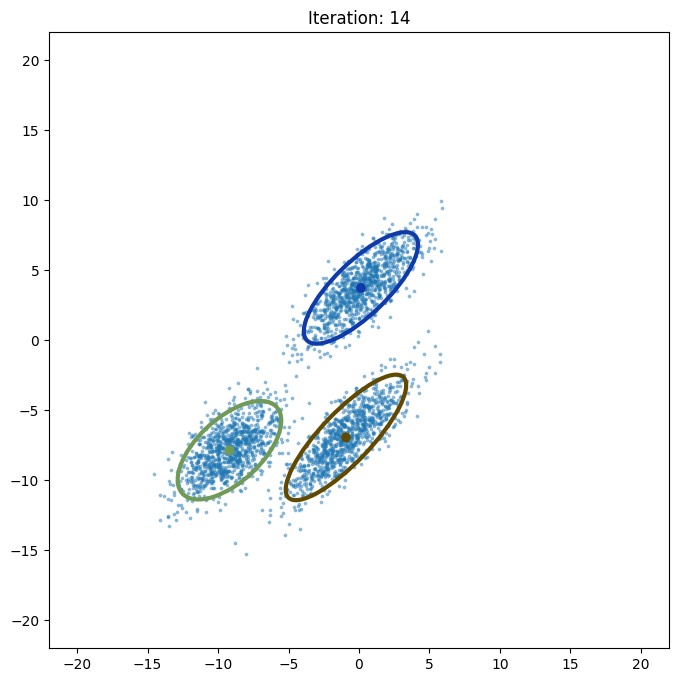

Iteration: 15, log-likelihood: -14635.4114


<Figure size 640x480 with 0 Axes>

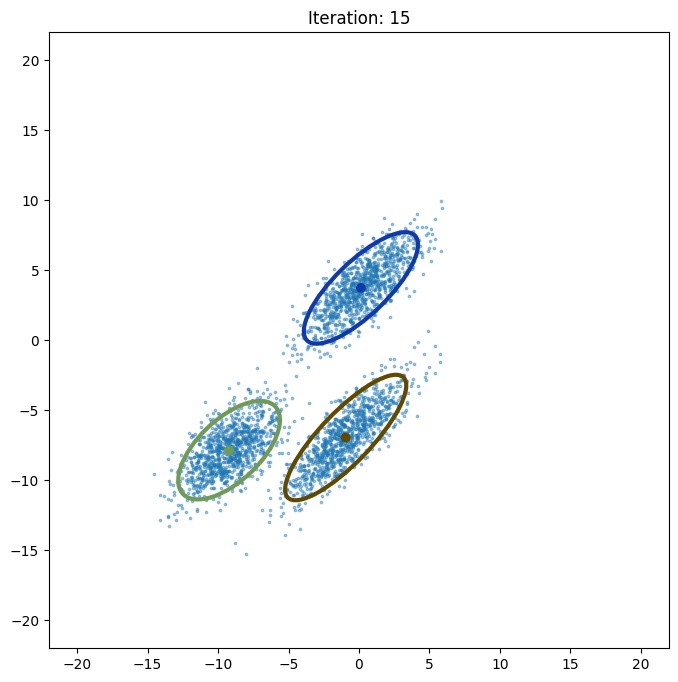

Iteration: 16, log-likelihood: -14635.3851


<Figure size 640x480 with 0 Axes>

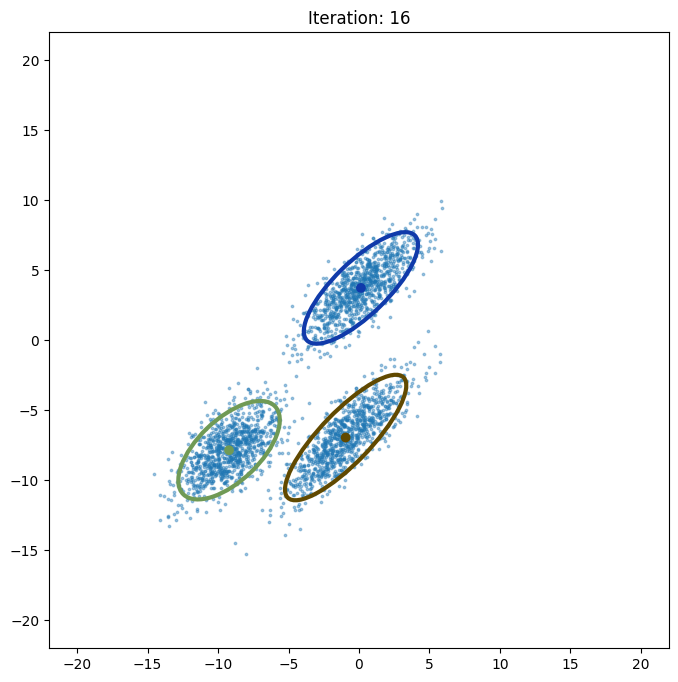

Iteration: 17, log-likelihood: -14635.3846


<Figure size 640x480 with 0 Axes>

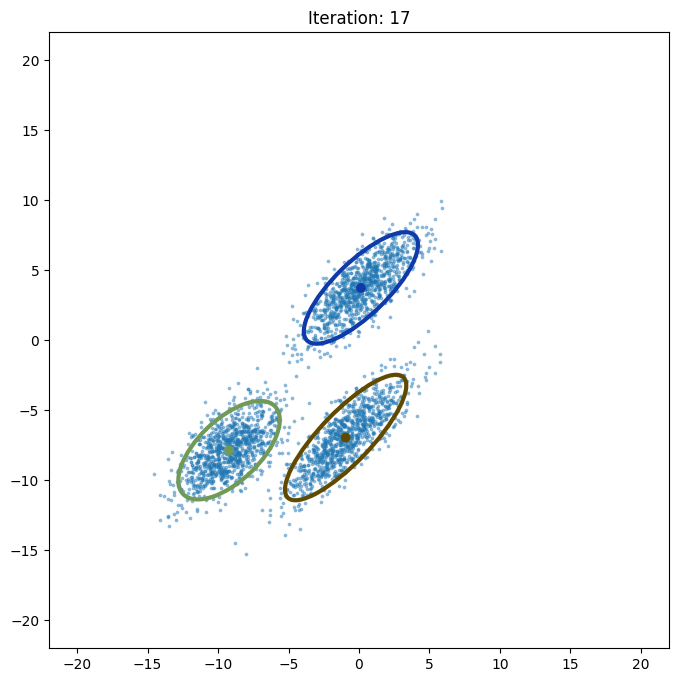

Iteration: 18, log-likelihood: -14635.3846


<Figure size 640x480 with 0 Axes>

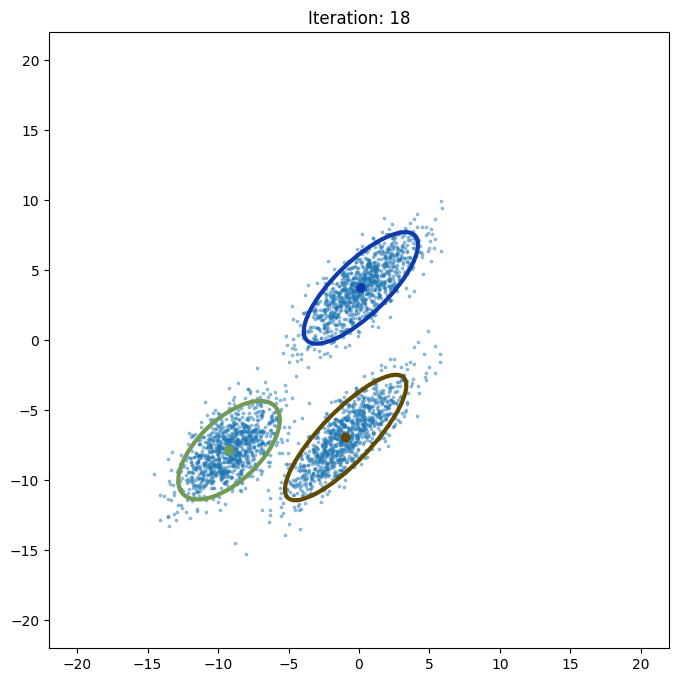

Iteration: 19, log-likelihood: -14635.3846


<Figure size 640x480 with 0 Axes>

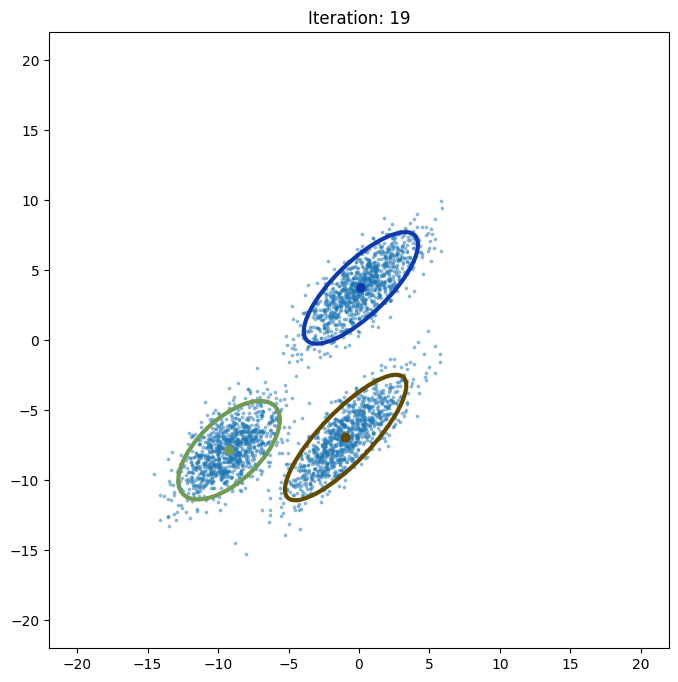

Iteration: 20, log-likelihood: -14635.3846


<Figure size 640x480 with 0 Axes>

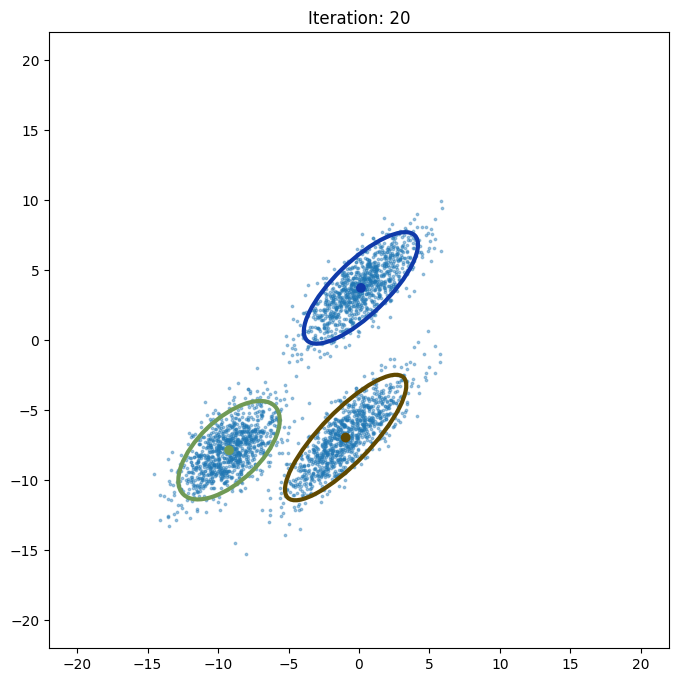

<Figure size 640x480 with 0 Axes>

In [ ]:
# train GMM using EM algorithm
gmm.init_em(X)
num_iters = 20

# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))


#### Example 3. GMM using sklearn

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
# Thư viện chứa model Gaussian Mixture

In [38]:
data = pd.read_csv('shopping-data.csv', header=0, index_col=0)
print(data.shape)
data.head()
# Lấy ra thu nhập va điểm shopping
X = data.iloc[:, 2:4].values
# Chuẩn hoá dữ liệu
std = MinMaxScaler()
X_std = std.fit_transform(X)
print(X_std.shape)

(200, 4)
(200, 2)


In [39]:
# Khởi tạo đối tượng mô hình GaussianMixture
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
gm.fit(X_std)
print('means: \n', gm.means_)
print('covariances: \n ', gm.covariances_)

means: 
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
covariances: 
  [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


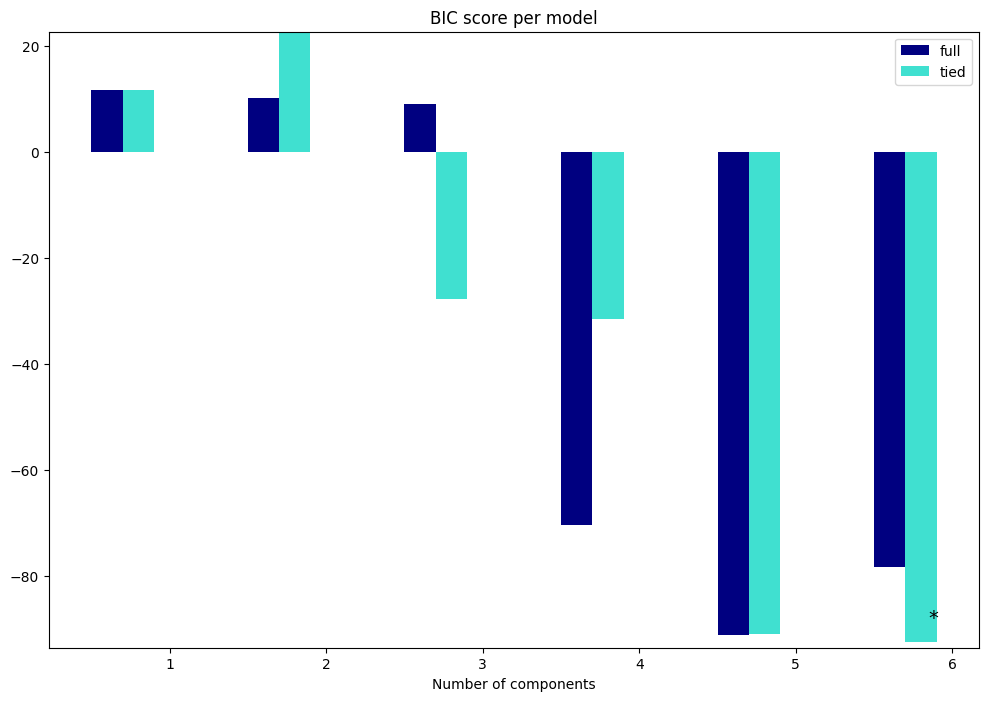

In [41]:
# chọn số K tốt nhất
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
# cv_types = ['spherical', 'tied', 'diag', 'full']

cv_types = ['full', 'tied']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit Gaussian mixture theo phương pháp huấn luyện EM
        gmm = GaussianMixture(n_components=n_components,
        covariance_type=cv_type)
        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))
        # Gán model có BIC scores thấp nhất là model tốt nhất
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise'])
clf = best_gmm
bars = []

# Vẽ biểu đồ BIC scores
plt.figure(figsize=(12, 8))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()]) 
plt.title('BIC score per model') 
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + \
      .2 * np.floor(bic.argmin() / len(n_components_range)) 
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14) 
plt.xlabel('Number of components') 
plt.legend([b[0] for b in bars], cv_types)

In [44]:
def _plot_kmean_scatter(X, labels): 
    ''' X: dữ liệu đầu vào labels: nhãn dự báo ''' 
    # lựa chọn màu sắc 
    num_classes = len(np.unique(labels)) 
    palette = np.array(sns.color_palette("hls", num_classes)) 
    
    # vẽ biểu đồ scatter 
    fig = plt.figure(figsize=(12, 8)) 
    ax = plt.subplot() 
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(np.int8)]) 
    
    # thêm nhãn cho mỗi cluster 
    txts = [] 
    for i in range(num_classes): 
        # Vẽ text tên cụm tại trung vị của mỗi cụm 
        xtext, ytext = np.median(X[labels == i, :], axis=0) 
        txt = ax.text(xtext, ytext, str(i), fontsize=24) 
        txt.set_path_effects([ PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]) 
        txts.append(txt) 
        plt.title('t-sne visualization')

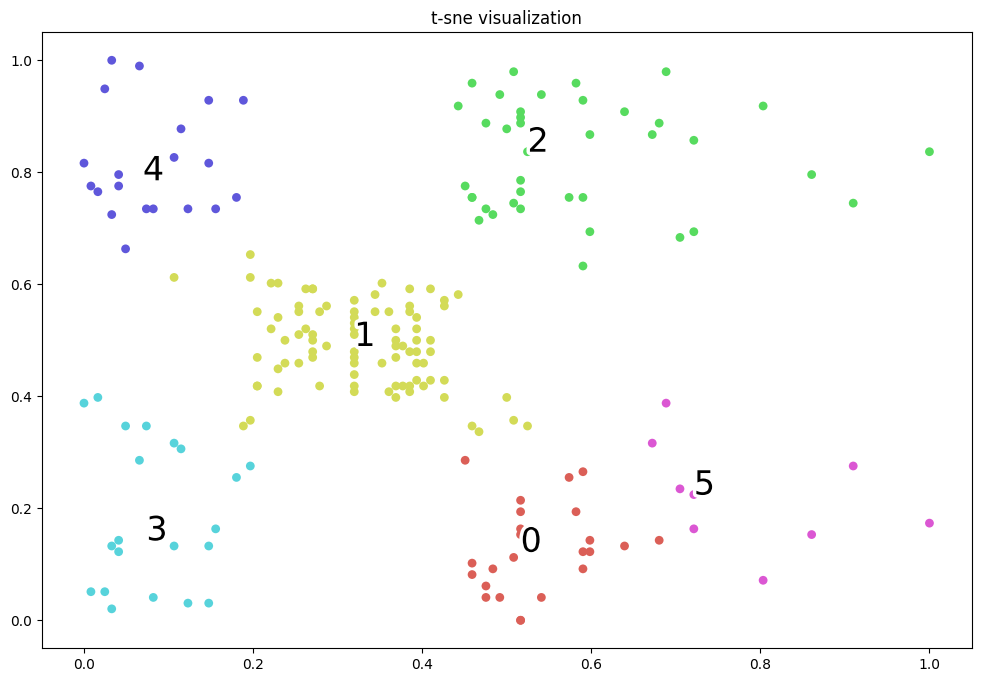

In [45]:
labels = best_gmm.predict(X_std) 
_plot_kmean_scatter(X_std, labels)